In [1]:
# baseball-predictor.ipynb based on hello-world-predictor
# Objective: Read the dataset, do a simple prediction for games on a given date using data prior to that date, then
#            and record some stats on how well it did.
# 
#
# 12/21/19, Alexis: Currently this "helloworld" predictor is very simple. It does the following:
#  1. Reads in the 2010 season as the baseline games dataset. It does some simple selection
#     of columns and generates a few calculated fields.
#  2. It prompts the user to specify 'game day' which are the games it is to predict.
#  3. It calculates the avg net number of runs for the home team (when playing at home) and
#     the avg net number of runs for the visiting team (when playing away).
#  4. For a given game, the predicted winner is the team with the greatest avg net runs at
#     home or away (as applicable).
#  5. The prediction is compared with the actual results that day, with % correct reported.
#
#  Proposed next steps:
#  1. Integrate Venkat's "concat" capability to combine datasets across year blocks to result
#     in a much larger dataset. Note that for development we may want to keep the dataset
#     smaller size so that it doesn't take a long time to run.
#  2. Move this out of jupyter notebook into standard Python and embed the prediction logic
#     into a function that can be called repeatedly with different dates.
#  3. Run trials with large numbers of dates to product large numbers of predictions and
#     results.
#  4. Write results to a file. Possibly generate some plot of results as a function of
#     training set window size.
#  5. Start experimenting with diffent prediction functions, initially across individual
#     factors, and then with multiple factors.
#  6. Consider a statistically meaningful regresssion analysis to select factors and training
#     set window size, by factor.
#  7. If someone has energy, consider using a web API to hit a website with current day
#     game schedule so we can predict games more recent than the dataset.
#
#
# 12/21/19, Venkat : Modified the code and included the below changes
#  1. Included the logic to combine all data files into one data frame
#  2. Included cleanup logic to clean missing data rows if any such rows exists
#
# 1/4/20, Alexis: Extend from "hello-world" to a useful predictor harness.
#  1. Implement a window to constrain the lookback period to n gamedays.
#
#
# 1/5/20, Venkat: Building the new prediction algorithm.
#                 Calculate Avg Net runs only for head-head teams, and see if it improves the forecst accuracy 




In [1]:
# Modules
import os
import csv
import pprint
import pandas as pd
import glob
import matplotlib.pyplot as plt

files = glob.glob("../datasets/Final_Data_Files/GL*.csv")
files.sort()

def reader(f):
    df = pd.read_csv(f, index_col=False, header=None)  
    df.columns = [("Col_"+str(i)) for i in range(1,df.shape[1]+1)]       

    return df

#season_df = pd.concat([reader(f) for f in files], keys=files)
season_df = pd.concat([reader(f) for f in files])

# season_df

In [2]:
season_df.shape # Useful to make sure we don't loose rows when adding column headers.

(19437, 161)

In [8]:
season_df = season_df.rename(columns={'Col_1':'Date',
                                     'Col_4':'Visiting Team',
                                     'Col_5':'Visiting League',
                                     'Col_7':'Home Team',
                                     'Col_8':'Home League',
                                     'Col_10':'Visiting Score',
                                     'Col_11':'Home Score',
                                     'Col_26':'Visiting Homerun',
                                     'Col_54':'Home Homerun'
                                     })
season_df = season_df[['Date', 'Visiting Team', 'Visiting League', 'Home Team', 'Home League',
                       'Visiting Score','Home Score','Visiting Homerun','Home Homerun']]
# season_df

In [9]:
# Identify incomplete rows
season_df.count()

Date                19437
Visiting Team       19437
Visiting League     19437
Home Team           19437
Home League         19437
Visiting Score      19437
Home Score          19437
Visiting Homerun    19437
Home Homerun        19437
dtype: int64

In [10]:
# Create a dataframe of unique game days with the game ID for the first game

# season_df.head()
gamedays = pd.Series(season_df['Date'].unique())
print(gamedays.head())
print(gamedays.tail())
print(type(gamedays.iloc[0]))

def gamedays_offset(base_date, n): # returns new game date offset by n
    base_date_index = gamedays[gamedays==base_date].index[0]
    if ((n + base_date_index) < 0) or n + base_date_index >= len(gamedays):
        raise ValueError(f"Attempting to caluclate a game date outside the range of the dataset.")
        return(0)  # Out of range
    else:
        new_index = base_date_index + n
#         print(f"new_index={new_index}")
        return gamedays.iloc[new_index]

# This is a manual test of the gamedays_offset() function.
print(gamedays_offset(20120406, -100))
    

0    20100404
1    20100405
2    20100406
3    20100407
4    20100408
dtype: int64
1433    20170927
1434    20170928
1435    20170929
1436    20170930
1437    20171001
dtype: int64
<class 'numpy.int64'>
20110622


In [11]:
# Drop all rows with missing information
season_df = season_df.dropna(how='any')
season_df.count()

Date                19437
Visiting Team       19437
Visiting League     19437
Home Team           19437
Home League         19437
Visiting Score      19437
Home Score          19437
Visiting Homerun    19437
Home Homerun        19437
dtype: int64

In [19]:
# Create a column 
season_df['Home Winner'] = season_df['Home Score'] > season_df['Visiting Score']
season_df['V NetRuns'] = season_df['Visiting Score'] - season_df['Home Score']
season_df['H NetRuns'] = - season_df['V NetRuns']
season_df['V AvgNetRuns'] = ""
season_df['H AvgNetRuns'] = ""
season_df['Predict Home Wins?'] = ""
season_df['Prediction Correct?'] = ""
season_df.head()

,Date,Visiting Team,Visiting League,Home Team,Home League,Visiting Score,Home Score,Visiting Homerun,Home Homerun,Home Winner,V NetRuns,H NetRuns,V AvgNetRuns,H AvgNetRuns,Predict Home Wins?,Prediction Correct?
0,20100404,NYA,AL,BOS,AL,7,9,2,1,True,-2,2,,,,
1,20100405,MIN,AL,ANA,AL,3,6,1,3,True,-3,3,,,,
2,20100405,CLE,AL,CHA,AL,0,6,0,2,True,-6,6,,,,
3,20100405,DET,AL,KCA,AL,8,4,0,1,False,4,-4,,,,
4,20100405,SEA,AL,OAK,AL,5,3,1,0,False,2,-2,,,,


In [13]:
# Ask the user how big of a window of prior game days should we evaluate.
good_value = False
while not good_value:
    lookback_n = int(input(f"How many gamedays back do you want the predictor to look? "))
    good_value = lookback_n > 0 and lookback_n < len(gamedays)

How many gamedays back do you want the predictor to look? 20


In [14]:
dataset_start_date = int(season_df['Date'].min())
start_date = gamedays_offset(dataset_start_date, lookback_n)
end_date = season_df['Date'].max()
print(f"dataset_start_date: {dataset_start_date}")
print(f"start_date: {start_date}")
print(f"end_date: {end_date}")

good_date = False
while not good_date:
    game_day = int(input(f"What is the game day (YYYYMMDD) you want us to predict (between {start_date} and {end_date}: "))
#    game_day = 20100715
    if game_day >= start_date and game_day <= end_date:
        game_day_df = season_df.loc[(season_df['Date'] == (game_day))]
        if len(game_day_df)==0:
            print("Sorry, no games are scheduled for that day")
        else:
            lookback_start_day = gamedays_offset(game_day, -lookback_n)
            lookback_end_day = gamedays_offset(game_day, -1)
            print(f"Lookback window starts {lookback_start_day} - {lookback_end_day}")
            train_df = season_df.loc[((season_df['Date'] < (game_day)) & (season_df['Date'] >= (lookback_start_day)))]
            gds = str(game_day)
            print(f"Nice! There are {len(game_day_df)} games on {gds[0:4]}-{gds[4:6]}-{gds[6:]}.")
            print(f"  We also have {len(train_df)} games in our training set, which should be plenty!")
            good_date = True
    else:
        print("Sorry, the date you selected is outside the range of our dataset.")

train_df.head()

dataset_start_date: 20100404
start_date: 20100424
end_date: 20171001
What is the game day (YYYYMMDD) you want us to predict (between 20100424 and 20171001: 20171001
Lookback window starts 20170911 - 20170930
Nice! There are 15 games on 2017-10-01.
  We also have 270 games in our training set, which should be plenty!


,Date,Visiting Team,Visiting League,Home Team,Home League,Visiting Score,Home Score,Visiting Homerun,Home Homerun,Home Winner,V NetRuns,H NetRuns,V AvgNetRuns,H AvgNetRuns,Predict Home Wins?,Prediction Correct?
2145,20170911,COL,NL,ARI,NL,5,4,1,0,False,1,-1,,,,
2146,20170911,PIT,NL,MIL,NL,7,0,3,0,False,7,-7,,,,
2147,20170911,LAN,NL,SFN,NL,6,8,1,2,True,-2,2,,,,
2148,20170911,DET,AL,CLE,AL,0,11,0,1,True,-11,11,,,,
2149,20170911,CHA,AL,KCA,AL,11,3,1,1,False,8,-8,,,,


In [15]:
# We now have the set of games we want to predict, and the training set defined.
# game_day_df2 = game_day_df.copy(deep=True)
game_day_df2 = game_day_df.copy(deep=True)
game_day_df2.head()

,Date,Visiting Team,Visiting League,Home Team,Home League,Visiting Score,Home Score,Visiting Homerun,Home Homerun,Home Winner,V NetRuns,H NetRuns,V AvgNetRuns,H AvgNetRuns,Predict Home Wins?,Prediction Correct?
2415,20171001,CIN,NL,CHN,NL,3,1,0,1,False,2,-2,,,,
2416,20171001,LAN,NL,COL,NL,6,3,0,0,False,3,-3,,,,
2417,20171001,ATL,NL,MIA,NL,8,5,2,1,False,3,-3,,,,
2418,20171001,NYN,NL,PHI,NL,0,11,0,2,True,-11,11,,,,
2419,20171001,SDN,NL,SFN,NL,4,5,1,1,True,-1,1,,,,


In [21]:
#v_teams = game_day_df2['Visiting Team'].to_list()
#v_team_net_score = []
#for team in v_teams:
#    v_team_net_score.append(train_df.loc[(train_df['Visiting Team']==team),:]['V NetRuns'].mean())
#game_day_df2['V AvgNetRuns'] = v_team_net_score

#h_teams = game_day_df2['Home Team'].to_list()
#h_team_net_score = []
#for team in h_teams:
#    h_team_net_score.append(train_df.loc[(train_df['Home Team']==team),:]['H NetRuns'].mean())
#game_day_df2['H AvgNetRuns'] = h_team_net_score

# prediction = [] # True means we predict home wins, False is visitor
# for game in game_day_df2:
#     print(type(game))
#     #prediction.append(game['H AvgNetRuns'] > game['V AvgNetRuns'])
# game_day_df2['Predict Home Wins?'] = prediction

# New Prediction Algorithm
v_team_net_score = []

for hteam, vteam in game_day_df2[['Home Team','Visiting Team']].itertuples(index=False):
    v_team_net_score.append(train_df.loc[(train_df['Visiting Team']==vteam) & (train_df['Home Team']==hteam),:]['V NetRuns'].mean())

game_day_df2['V AvgNetRuns'] = v_team_net_score


h_team_net_score = []

for hteam, vteam in game_day_df2[['Home Team','Visiting Team']].itertuples(index=False):
    h_team_net_score.append(train_df.loc[(train_df['Home Team']==hteam) & (train_df['Visiting Team']==vteam),:]['H NetRuns'].mean())
game_day_df2['H AvgNetRuns'] = h_team_net_score
game_day_df2['Predict Home Wins?'] = game_day_df2['H AvgNetRuns'] > game_day_df2['V AvgNetRuns']

game_day_df2.head()

,Date,Visiting Team,Visiting League,Home Team,Home League,Visiting Score,Home Score,Visiting Homerun,Home Homerun,Home Winner,V NetRuns,H NetRuns,V AvgNetRuns,H AvgNetRuns,Predict Home Wins?,Prediction Correct?
2415,20171001,CIN,NL,CHN,NL,3,1,0,1,False,2,-2,-5.0,5.0,True,
2416,20171001,LAN,NL,COL,NL,6,3,0,0,False,3,-3,-3.0,3.0,True,
2417,20171001,ATL,NL,MIA,NL,8,5,2,1,False,3,-3,-5.0,5.0,True,
2418,20171001,NYN,NL,PHI,NL,0,11,0,2,True,-11,11,-0.5,0.5,True,
2419,20171001,SDN,NL,SFN,NL,4,5,1,1,True,-1,1,-3.5,3.5,True,


In [20]:
#sum_game_day_df2 =game_day_df2. groupby(['Home Team']).sum()
#sum_game_day_df2.head()

,Date,Visiting Score,Home Score,Visiting Homerun,Home Homerun,Home Winner,V NetRuns,H NetRuns,V AvgNetRuns,H AvgNetRuns,Predict Home Wins?
Home Team,,,,,,,,,,,
ANA,20171001,2,6,1,1,True,-4,4,0.500000,-0.500000,False
BOS,20171001,4,3,0,0,False,1,-1,2.666667,-2.666667,False
CHN,20171001,3,1,0,1,False,2,-2,-5.000000,5.000000,True
CLE,20171001,1,3,1,0,True,-2,2,-4.000000,4.000000,True
COL,20171001,6,3,0,0,False,3,-3,-3.000000,3.000000,True


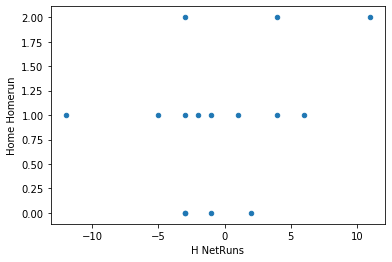

In [18]:
df=game_day_df2[["Home Homerun","H NetRuns"]]
df.plot(kind='scatter',x="H NetRuns", y="Home Homerun")

In [13]:
# Evaluate the predictions
game_day_df2['Prediction Correct?'] = game_day_df2['Predict Home Wins?'] == game_day_df2['Home Winner']
game_day_df2_correct = game_day_df2.loc[(game_day_df2['Prediction Correct?']),:]
print(f"{game_day}: {len(game_day_df2)} games with {len(game_day_df2_correct)} predicted correctly.")
print(f"{round((len(game_day_df2_correct)/len(game_day_df2)*100.),1)}%")
game_day_df2[['Date', 'Visiting Team', 'Home Team', 'Visiting Score', 'Home Score', 'Home Winner',
              'V AvgNetRuns', 'H AvgNetRuns', 'Predict Home Wins?', 'Prediction Correct?']]

20171001: 15 games with 4 predicted correctly.
26.7%


,Date,Visiting Team,Home Team,Visiting Score,Home Score,Home Winner,V AvgNetRuns,H AvgNetRuns,Predict Home Wins?,Prediction Correct?
2415,20171001,CIN,CHN,3,1,False,-2.833333,2.833333,True,False
2416,20171001,LAN,COL,6,3,False,-3.000000,3.000000,True,False
2417,20171001,ATL,MIA,8,5,False,-5.000000,5.000000,True,False
2418,20171001,NYN,PHI,0,11,True,2.000000,-2.000000,False,False
2419,20171001,SDN,SFN,4,5,True,0.166667,-0.166667,False,False
2420,20171001,MIL,SLN,6,1,False,0.500000,-0.500000,False,True
2421,20171001,PIT,WAS,11,8,False,-1.000000,1.000000,True,False
2422,20171001,SEA,ANA,2,6,True,1.800000,-1.800000,False,False
2423,20171001,HOU,BOS,4,3,False,2.666667,-2.666667,False,True
2424,20171001,CHA,CLE,1,3,True,-4.000000,4.000000,True,True


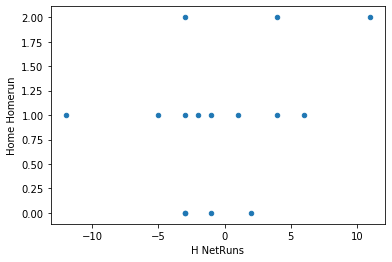

In [17]:
df=game_day_df2[["Home Homerun","H NetRuns"]]
df.plot(kind='scatter',x="H NetRuns", y="Home Homerun")